In [1]:
import ess # self-built module for battery related function
import preprocess # self-built module for preprocess related function
import rl_model # self-built module for reinforcement learning related function
import predictive_model # self-built module for prediction related function
import numpy as np
import pandas as pd
from scipy.optimize import linprog

import warnings
warnings.filterwarnings("ignore")

/home/chongaih/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Declare Function 

In [2]:
import numpy as np
from scipy.optimize import linprog

In [3]:
# Linear programming optimization

def optimize_linprog(pv, load, price, battery, num_timesteps):
    
    """
      1. x(t) - action at time t (within the range [-1, 1])
         p(t) - real time price at time t
         k - wear and tear cost of ESS
         P - per unit rated power of ESS
         E - per unit rated energy of ESS

         objective: minimize the transactive cost across the next 24 hours
                    min (x1*(p1+k) + x2*(p2+k) + ... + x24*(p24+k))
         inequality constraint: operation limit - 0 <= x(t) * P / E + SOC(t) <= 1
         bounds: upper and lower bound of action [-1, 1]
         return: action of next 24 hours
      2. the actual ESS output power = action * P
      3. the SOC of ESS is updated after each hour and the linear programming optimization 
         is performed every hour with the updated data - model prediction control
    """

    # coefficients of the linear objective function to be minimized
    # coefficients is normalized with load and pv such that 
    # ESS will react normally if there is no PV
    # ESS tend to store more PV when PV is much higher than load
    c = (price + battery.wear_cost) * load / (load + pv) * battery.P_rated

    # Inequality constraint - 0 <= x1 / E + SOC1 <= 1
    Aup = np.ones((24, 24)) * battery.P_rated / battery.E_rated 
    Aup = np.tril(Aup)
    Adown = np.flipud(Aup) * -1
    A = np.concatenate((Aup, Adown), axis=0) 
    bup = np.ones((24,)) - battery.current_SOC
    bdown = np.zeros((24,)) + battery.current_SOC - battery.target_SOC
    b = np.concatenate((bup, bdown), axis=0)

    # upper and lower bounds of the actions
    bounds = []
    for timestep in range(num_timesteps):
        bounds.append((-1, 1))

    # linear programming
    res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='revised simplex')
    actions = res.x
    
    return actions

In [4]:
# Compute the monetary cost or benefit with/ without ESS/ battery
# compute_benefit(x[:, 0:1], x[:, 1:2], x[:, 2:3], np.array([[0.]*len(x)]).transpose(), battery=None)

def compute_benefit(pv_energy, load_energy, price, battery_energy, battery=None):
    
    # Reshape from 1d to 2d array and inverse_transform
    if len(pv_energy.shape) == 1:
        load_energy = np.reshape(load_energy, (1, -1))
        pv_energy = np.reshape(pv_energy, (1, -1))
        battery_energy = np.reshape(battery_energy, (1, -1))
        price = np.reshape(price, (1, -1))
    
    load_energy = preprocess_tool.sc_energy.inverse_transform(load_energy) # pu to kWh
    pv_energy = preprocess_tool.sc_energy.inverse_transform(pv_energy) # pu to kWh
    battery_energy = preprocess_tool.sc_energy.inverse_transform(battery_energy) # pu to kWh
    price = preprocess_tool.sc_price.inverse_transform(price) / 100 # pu to cents/kWh to $/kWh
    
    # Compute the transaction cost
    net_energy = load_energy - pv_energy + battery_energy
    cost_transaction = price * net_energy
    
    # Compute the wear and tear cost
    if battery:
        cost_wear = preprocess_tool.sc_price.inverse_transform(battery.wear_cost) * battery_energy
    else:
        cost_wear = 0
            
    return -np.sum(cost_transaction + cost_wear)


## Main

In [5]:
# Declare preprocessing tool which contains the trained scalers and 
# functions for feature engineering and formatting for prediction
preprocess_tool = preprocess.preprocess()

# Declare the predictive model for load, price and pv
model_load, model_price, model_pv = predictive_model.retrieve_model()

# Declare the reinforcement learning model for action decision
model_averse, model_seeking = rl_model.retrieve_model()

# Declare battery used in respective cases
# Solution solved using linear programming is continuous
# Solution solved using reinforcement learing is discrete
battery_lp_perfect = ess.battery_continuous()
battery_lp_predict = ess.battery_continuous()
battery_rl_averse = ess.battery_discrete()
battery_rl_seeking = ess.battery_discrete()

In [6]:
# Parameters used in prediction
timesteps_in = 336 # data two week prior to the target
timesteps_out = 24

## To be finetuned

In [7]:
# TO BE REPLACED WITH INFLUX/ SQL DATA
# Load the data
df = pd.read_csv("Final Modified Data_Rev2.csv")
df = df.iloc[:1000, :]

In [8]:
import time

In [9]:
battery_lp_perfect = ess.battery_continuous()
battery_lp_predict = ess.battery_continuous()
battery_rl_averse = ess.battery_discrete()
battery_rl_seeking = ess.battery_discrete()

# TO BE REPLACED WITH INFLUX/ SQL STORE DATA
cost_woess = []

SOC_perfect = []
action_perfect = []
cost_wess_perfect = []

SOC_predict = []
action_predict = []
cost_wess_predict = []

SOC_averse = []
action_averse = []
cost_wess_averse = []

SOC_seeking = []
action_seeking = []
cost_wess_seeking = []

i = timesteps_in

start = time.time()

while i <= len(df) - timesteps_out:
    
    """PERFECT KNOWLEDGE"""
    # TO BE REPLACED WITH INFLUX/ SQL STORE DATA    
    # Data to be read from database
    df_perfect = df.iloc[i:i+timesteps_out, :]
    df_perfect = preprocess_tool.feature_engineering(df_perfect)
    x = preprocess_tool.normalize_pv_load_price(df_perfect)

    # Linear programming optimization with perfect knowledge
    pv, load, price = x[:, 0], x[:, 1], x[:, 2]
    actions_perfect = optimize_linprog(pv, load, price, battery_lp_perfect, timesteps_out)

    # TO BE REPLACED WITH INFLUX/ SQL STORE DATA
    # Update SOC and store SOC, cost & action
    SOC_perfect.append(battery_lp_perfect.update_SOC(actions_perfect[0]))
    action_perfect.append(actions_perfect[0])  
    cost_wess_perfect.append(compute_benefit(pv[0:1], load[0:1], price[0:1],
                                     actions_perfect[0:1]*battery_lp_perfect.P_rated, 
                                     battery_lp_perfect))
    cost_woess.append(compute_benefit(pv[0:1], load[0:1], price[0:1], np.array([0.])))  

    """PREDICTED KNOWLEDGE"""
    # TO BE REPLACED WITH INFLUX/ SQL STORE DATA    
    # Data to be read from database
    df_prior = df.iloc[i-timesteps_in:i, :]
    df_prior = preprocess_tool.feature_engineering(df_prior)
    x_prior = preprocess_tool.normalize_pv_load_price(df_prior)

    # (336,) + (336, 40) --> (336, 41) --> (1, 336, 41)
    x_load = np.concatenate((np.expand_dims(x_prior[:,1], axis=1), df_prior.iloc[:, 12:].values), axis=-1)
    x_load = np.expand_dims(x_load, axis=0)
    x_price = np.concatenate((np.expand_dims(x_prior[:,2], axis=1), df_prior.iloc[:, 12:].values), axis=-1)
    x_price = np.expand_dims(x_price, axis=0)
    x_pv = np.concatenate((np.expand_dims(x_prior[:,0], axis=1), df_prior.iloc[:, 12:].values), axis=-1)
    x_pv = np.expand_dims(x_pv, axis=0)

    load_pred = model_load.predict(x_load[:, :, :], False)
    load_pred = np.array(load_pred[0])[0, :, 0]
    price_pred = model_price.predict(x_price[:, :, :], False)
    price_pred = np.array(price_pred[0])[0, :, 0]
    pv_pred = model_pv.predict(x_pv[:, :, :])
    pv_pred = pv_pred[0, :, 0]
    
    # Linear programming optimization with predicted knowledge
    actions_predict = optimize_linprog(pv_pred, load_pred, price_pred, battery_lp_predict, timesteps_out)    
    
    # TO BE REPLACED WITH INFLUX/ SQL STORE DATA
    # Update SOC and store SOC, cost & action
    SOC_predict.append(battery_lp_predict.update_SOC(actions_predict[0]))
    action_predict.append(actions_predict[0])
    cost_wess_predict.append(compute_benefit(pv[0:1], load[0:1], price[0:1],
                                     actions_predict[0:1]*battery_lp_predict.P_rated, 
                                     battery_lp_predict)) # Use actual pv, load, price for computation
    
    """REINFORCEMENT LEARNING"""
    # TO BE REPLACED WITH INFLUX/ SQL STORE DATA    
    # Data to be read from database
    df_rl = df.iloc[i-24:i+1, :]
    df_rl = preprocess_tool.feature_engineering(df_rl)
    x = preprocess_tool.normalize_pv_load_price(df_rl)

    # Risk averse and seeking reinforcement learning
    pv, load, price = x[24, 0], x[24, 1], x[24, 2]
    price_avg = np.mean(x[:24, 2])

    # per unit pv, load, price, SOC, average price of past 24 hours
    state_averse = np.array([[pv, load, price, battery_rl_averse.current_SOC, price_avg]])
    state_seeking = np.array([[pv, load, price, battery_rl_seeking.current_SOC, price_avg]])
    
    # Discrete solution ranging from [-1, 1] with interval of 0.2
    action_a = battery_rl_averse.action_set[np.argmax(model_averse.predict(state_averse))]
    action_s = battery_rl_seeking.action_set[np.argmax(model_averse.predict(state_seeking))]

    # TO BE REPLACED WITH INFLUX/ SQL STORE DATA
    # Update SOC and store SOC, cost & action
    SOC_averse.append(battery_rl_averse.update_SOC(action_a))
    SOC_seeking.append(battery_rl_seeking.update_SOC(action_s))
    action_averse.append(action_a)
    action_seeking.append(action_s)
    cost_wess_averse.append(compute_benefit(np.array([pv]), np.array([load]), np.array([price]), 
                                            np.array([action_a])*battery_rl_averse.P_rated, 
                                            battery_rl_averse))
    cost_wess_seeking.append(compute_benefit(np.array([pv]), np.array([load]), np.array([price]), 
                                             np.array([action_s])*battery_rl_seeking.P_rated, 
                                             battery_rl_seeking)) 

    if (i-timesteps_in) % 20 == 0:
        print ("Computation at step {} completed".format(i-timesteps_in))        

    i += 1
    
end = time.time()
print ("Total time: {:2f}s".format(end - start))

Computation at step 0 completed
Computation at step 20 completed
Computation at step 40 completed
Computation at step 60 completed
Computation at step 80 completed
Computation at step 100 completed
Computation at step 120 completed
Computation at step 140 completed
Computation at step 160 completed
Computation at step 180 completed
Computation at step 200 completed
Computation at step 220 completed
Computation at step 240 completed
Computation at step 260 completed
Computation at step 280 completed
Computation at step 300 completed
Computation at step 320 completed
Computation at step 340 completed
Computation at step 360 completed
Computation at step 380 completed
Computation at step 400 completed
Computation at step 420 completed
Computation at step 440 completed
Computation at step 460 completed
Computation at step 480 completed
Computation at step 500 completed
Computation at step 520 completed
Computation at step 540 completed
Computation at step 560 completed
Computation at step 

In [10]:
print ("Cost without ESS: ${:4f}".format(-np.sum(cost_woess)))
print ("Cost with ESS linear programming perfect knowledge: ${:2f}".format(-np.sum(cost_wess_perfect)))
print ("Cost with ESS linear programming predicted knowledge: ${:2f}".format(-np.sum(cost_wess_predict)))
print ("Cost with ESS reinforcement learning risk averse: ${:2f}".format(-np.sum(cost_wess_averse)))
print ("Cost with ESS reinforcement learning risk seeking: ${:2f}".format(-np.sum(cost_wess_seeking)))

Cost without ESS: $1512675.194560
Cost with ESS linear programming perfect knowledge: $1471824.313015
Cost with ESS linear programming predicted knowledge: $1476235.113015
Cost with ESS reinforcement learning risk averse: $1496017.580037
Cost with ESS reinforcement learning risk seeking: $1496017.580037


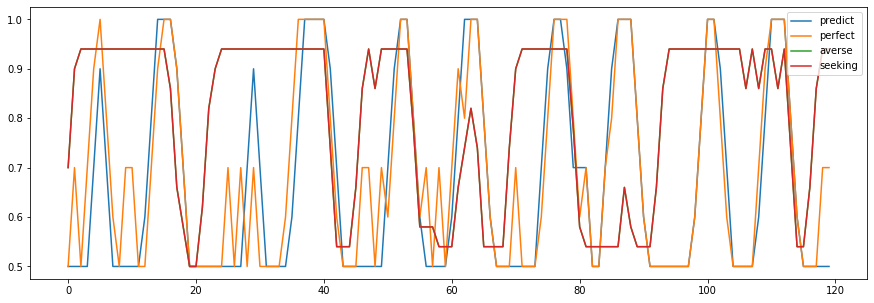

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(SOC_predict[:120], label='predict')
plt.plot(SOC_perfect[:120], label='perfect')
plt.plot(SOC_averse[:120], label='averse')
plt.plot(SOC_seeking[:120], label='seeking')
plt.legend()
plt.show()

In [ ]:
"""
from sklearn.metrics import mean_absolute_error as mae

x_test, y_test =  preprocess_tool.get_sequential_data(timesteps_in, timesteps_out, x[:, 0], df.iloc[:, 12:].values)
pv_pred = model_pv.predict(x_test[:, :, :])
pv_pred = np.array(pv_pred[:, :, 0])
mae(pv_pred, y_test[:,:,0])

x_test, y_test =  preprocess_tool.get_sequential_data(timesteps_in, timesteps_out, x[:, 1], df.iloc[:, 12:].values)
load_pred, _, _ = model_load.predict(x_test[:, :, :], False)
load_pred = np.array(load_pred[:, :, 0])
mae(load_pred, y_test[:,:,0])

x_test, y_test = preprocess_tool.get_sequential_data(timesteps_in, timesteps_out, x[:, 2], df.iloc[:, 12:].values)
price_pred, _, _ = model_price.predict(x_test[:, :, :], False)
price_pred = np.array(price_pred[:, :, 0])
mae(price_pred, y_test[:,:,0])
"""